In [1]:
# Set the working directory to the parent directory
import sys
sys.path.append('..')
sys.dont_write_bytecode = True

import os
os.chdir("..")

# Import relevant packages
from src.eda import data_info
from src.explainability import ShapKernelExplainer

# Import necessary libraries
import shap
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'  # or other, 'dejavuserif'
plt.rcParams['font.family'] = 'serif'  # or 'DejaVu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 'DejaVu Serif' serif' 'Times'
plt.rcParams['font.size'] = 9

In [2]:
# Chosen tuning objective
metric = "AUC"

## 1. Visualize the SHAP values

(11457, 64)
(11457, 64)
(11457, 64)
(11457, 64)


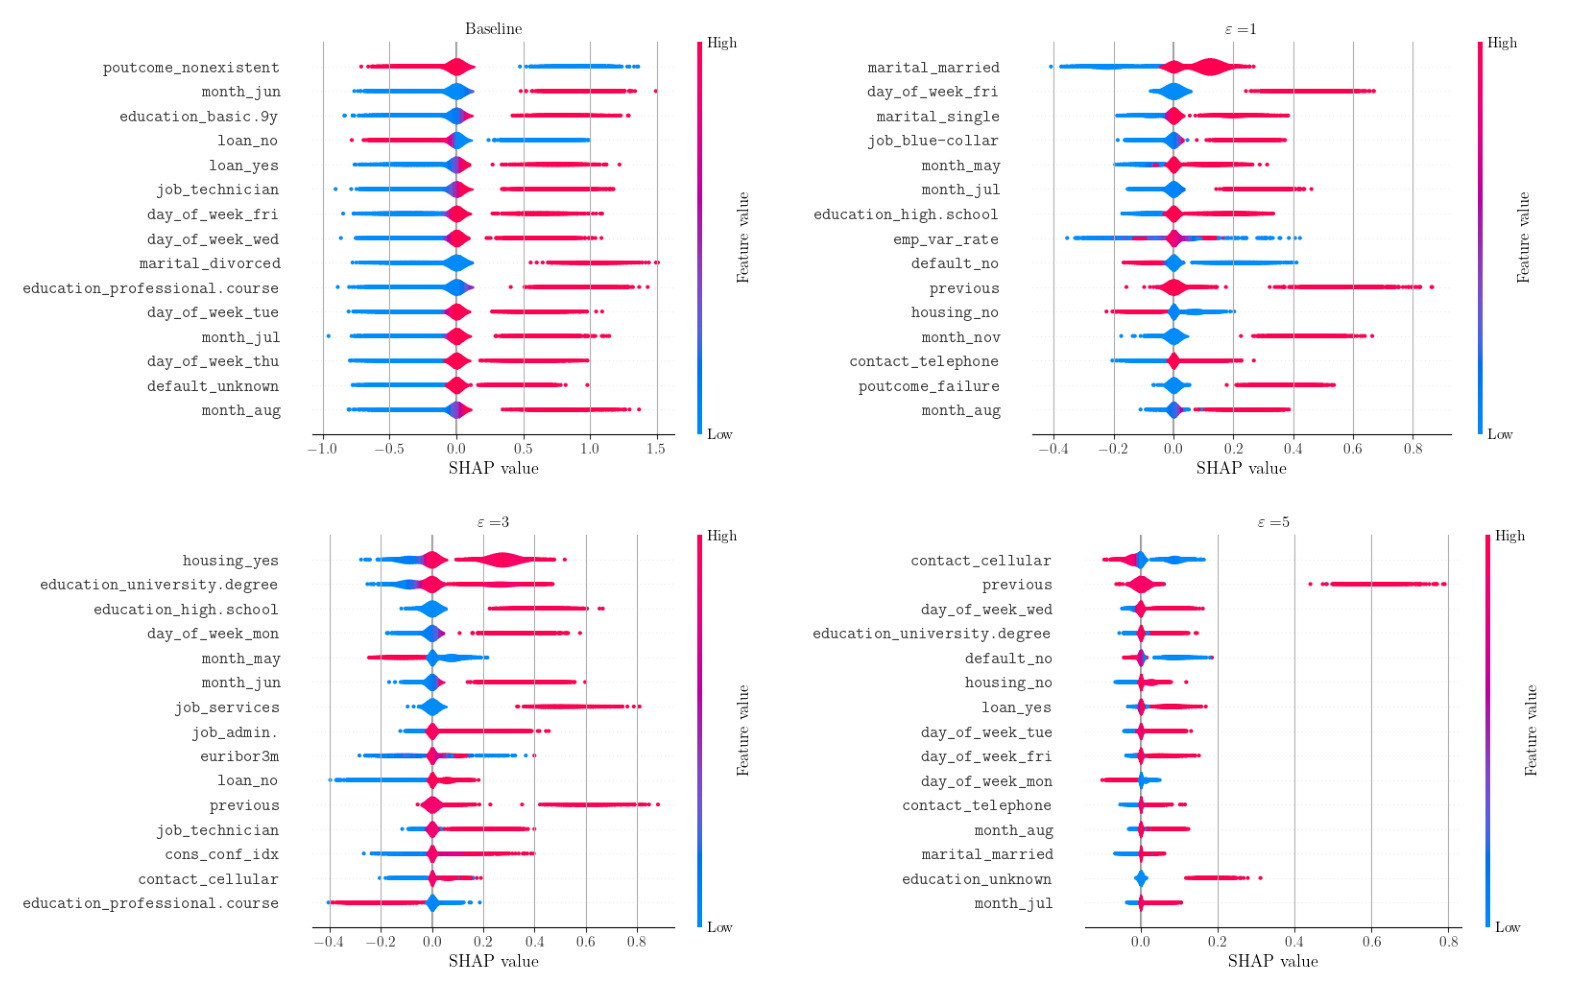

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # 2 rows x 2 cols
# Flatten the axes array for easier indexing
axes = axes.flatten()
j = 0

for model_type in ["baseline", "dpsgd"]:
    # Initialize the SHAP explainer
    shap_init = ShapKernelExplainer(model_type=model_type, metric=metric)
    # Get the model version and predictions
    for i, row in shap_init.model_info.iterrows():
        version = row["version"]
        y_pred = pd.read_feather(f"experiments/predictions/{shap_init.model_type}/{version}_pred.feather")
        # Get the input of anomalies
        #x_anomaly = shap_init.X_test[y_pred['anomaly']==1].values
        # Get the SHAP values
        try:
            explanation = pd.read_feather(f"results/explainability/{model_type}/{version}.feather")
        except FileNotFoundError:
            continue
        shap_values = explanation.values
        print(shap_values.shape)
        # Plot the SHAP values
        if model_type == "baseline":
            title = "Baseline"
        else:
            title = r"$\varepsilon =$" + f"{row['epsilon']:.0f}"
        # Create a temporary figure
        temp_fig = plt.figure()
        shap.summary_plot(shap_values,
                    features=shap_init.X_test.values,
                    feature_names=[f"\\texttt{{{col}}}" for col in shap_init.all_cols],
                    show=False,
                    plot_size=(8, 5),
                    max_display=15,
                    plot_type="violin",
                    title=title,
                    )
        # Draw the canvas, copy contents, and close temp
        temp_fig.canvas.draw()
        image = np.frombuffer(temp_fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(temp_fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(temp_fig)

        # Show the image in the target subplot
        axes[j].imshow(image)
        axes[j].axis("off")
        j += 1

plt.tight_layout()
plt.savefig(f"results/figures/shap_values.png", bbox_inches='tight', dpi=300)
plt.show()